In [1]:
import pandas as pd
import numpy as np
import twosigmafunc
from collections import defaultdict

In [29]:
import matplotlib.pyplot as plt
import seaborn
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [20]:
train = pd.read_hdf('train.h5')

In [21]:
markers = [ 'o', 'v', 's','*', ',', '+', 'x', '2', '3', 'D', '|', '*', ',']

In [22]:
excl = ['id', 'timestamp', 'y']
cols_origin = [col for col in train.columns if col not in ['y']]
feature_origin = [col for col in train.columns if col not in excl]
feature_diff = [col + '_diff' for col in feature_origin]


# Add Nans 

In [7]:
twosigmafunc.add_nans(train, feature_origin)

sucessfully add 108 nan features


# Add differs 

In [23]:
# add time series diff
train.fillna(train.median(), inplace=True)
d_mean = train.median()
train.sort_values(['id', 'timestamp'], inplace=True)
train['id_diff'] = train.id.diff()
d_mean['id_diff'] = 0.0
for col in feature_origin:
    train[col + '_diff'] = train[col].diff()
    d_mean[col + '_diff'] = 0.0

train.loc[train.id_diff!=0, feature_diff] = 0


In [11]:
train.head()

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_40_diff,technical_41_diff,technical_42_diff,technical_43_diff,technical_44_diff,y_past,tec20-30,tec123,tec123_diff,tec20-30_diff
131062,0,167,-0.000837,0.005523,0.021095,0.002476,0.011752,-0.040645,-0.007395,-0.030291,...,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
131895,0,168,-0.000837,0.005523,0.021095,0.002476,0.011752,-0.040645,-0.007395,-0.030291,...,0.00000,0.0,0.0,0.000000,0.0,-0.007108,0.0,0.0,0.0,0.0
132728,0,169,-0.000837,0.005523,0.021095,0.002476,0.011752,-0.040645,-0.007395,-0.030291,...,0.00000,0.0,0.0,0.000000,0.0,0.001950,0.0,0.0,0.0,0.0
133561,0,170,-0.230583,0.488096,0.935920,0.028222,-0.083071,-0.240929,-0.007395,0.212425,...,-0.14571,0.0,0.0,0.659754,0.0,0.017724,0.0,0.0,0.0,0.0
134393,0,171,-0.230583,0.488096,0.935920,0.028222,-0.083071,-0.240929,-0.007395,0.212425,...,0.00000,0.0,0.0,0.000000,0.0,0.012934,0.0,0.0,0.0,0.0


In [24]:
train['y_past'] = train.y.shift()
train['tec20-30'] = train.technical_20 - train.technical_30
train['tec123'] = train['tec20-30'] + train.technical_13
train['tec123_diff'] = train.tec123.diff()
train['tec20-30_diff'] = train['tec20-30'].diff()
train.loc[train.id_diff != 0, ['tec123_diff', 'tec20-30_diff', 'y_past']] = 0

# Univariate Analyse 

In [7]:
np.corrcoef(train.y, train.technical_20)[0][1]

-0.016415424597372153

In [8]:
np.corrcoef(train.y, train.tec123)[0][1]

-0.019391722348073601

In [10]:
np.corrcoef(train.y, train['tec20-30'])[0][1]

-0.01968184848890895

In [11]:
np.corrcoef(train.y, train.tec123 - train.technical_13)[0][1]

-0.019707271053060298

In [25]:
feature_cols = ['timestamp', 'y_past', 'tec123', 'tec123_diff', 'tec20-30', 'tec20-30_diff', 'technical_20', 'technical_30', 'technical_20_diff', 'technical_30_diff']
X_train, y_train, X_test, y_test = twosigmafunc.split_data(train, feature_cols)

In [8]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 904458 entries, 806298 to 1710755
Data columns (total 9 columns):
timestamp            904458 non-null int16
tec123               904458 non-null float32
tec123_diff          904458 non-null float32
tec20-30             904458 non-null float32
tec20-30_diff        904458 non-null float32
technical_20         904458 non-null float32
technical_30         904458 non-null float32
technical_20_diff    904458 non-null float32
technical_30_diff    904458 non-null float32
dtypes: float32(8), int16(1)
memory usage: 36.2 MB


In [26]:
del train

timestamp prepare

* Univariate Linear Model

In [16]:
from sklearn.linear_model import LinearRegression, Ridge
lr = LinearRegression(n_jobs=-1)
ridge = Ridge()

In [17]:
low_y_cut = -0.075
high_y_cut = 0.075
y_is_above_cut = (y_train > high_y_cut)
y_is_below_cut = (y_train < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)

In [18]:
min_stamp = X_test.timestamp.min()
max_stamp = X_test.timestamp.max()

In [27]:
reward = defaultdict(list)
for feature in feature_cols[1:]:
    print('processing', feature)
    lr.fit(np.array(X_train.loc[y_is_within_cut, feature]).reshape(-1,1), y_train.loc[y_is_within_cut])
    stamp = min_stamp
    y_true_acc = []
    y_pred_acc = []
    while stamp <= max_stamp:
        test = np.array(X_test.loc[X_test.timestamp == stamp, feature]).reshape(-1,1)
        y_true = y_test.loc[X_test.timestamp == stamp]
        y_pred = lr.predict(test)
#         print(y_true.shape, y_pred.shape)
        y_true_acc.extend(list(y_true))
        y_pred_acc.extend(list(y_pred))
        reward[feature].append(twosigmafunc.R_score(np.array(y_pred_acc), np.array(y_true_acc)))
        stamp += 1
        

processing y_past
processing tec123
processing tec123_diff
processing tec20-30
processing tec20-30_diff
processing technical_20
processing technical_30
processing technical_20_diff
processing technical_30_diff


(-0.15, 0.07)

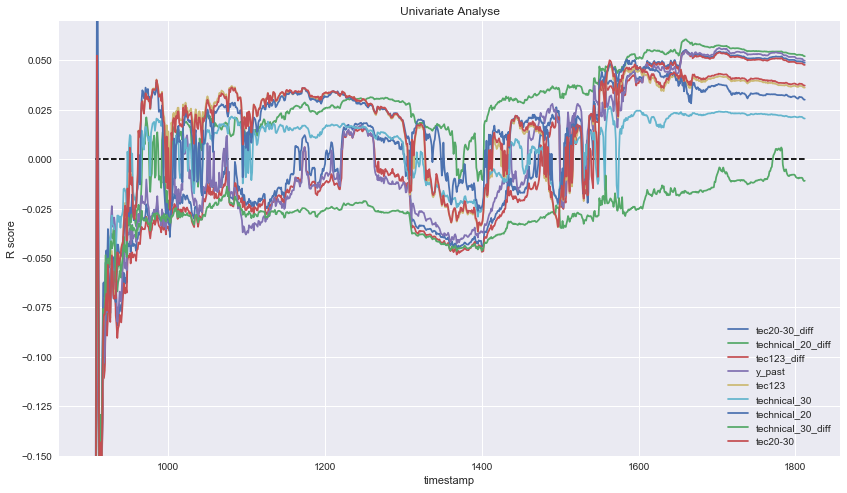

In [30]:
plt.title('Univariate Analyse')
plt.xlabel('timestamp')
plt.ylabel('R score')
plt.plot([min_stamp, max_stamp], [0, 0], 'k--')
for key in reward.keys():
    plt.plot(range(min_stamp, max_stamp + 1), np.array(reward[key]) * 2, label=key)
plt.legend(loc='best')
plt.ylim(-0.15, 0.07)

from above figure, we can say `technical_20_diff` is best feature for univariate linear model

### Ridge 

In [38]:
reward_ridge = defaultdict(list)
model = ridge
for feature in feature_cols[1:]:
    print('processing', feature)
    model.fit(np.array(X_train.loc[y_is_within_cut, feature]).reshape(-1,1), y_train.loc[y_is_within_cut])
    stamp = min_stamp
    y_true_acc = []
    y_pred_acc = []
    while stamp <= max_stamp:
        test = np.array(X_test.loc[X_test.timestamp == stamp, feature]).reshape(-1,1)
        y_true = y_test.loc[X_test.timestamp == stamp]
        y_pred = model.predict(test)
#         print(y_true.shape, y_pred.shape)
        y_true_acc.extend(list(y_true))
        y_pred_acc.extend(list(y_pred))
        reward_ridge[feature].append(twosigmafunc.R_score(np.array(y_pred_acc), np.array(y_true_acc)))
        stamp += 1
        

processing tec123
processing tec123_diff
processing tec20-30
processing tec20-30_diff
processing technical_20
processing technical_30
processing technical_20_diff
processing technical_30_diff


(-0.15, 0.07)

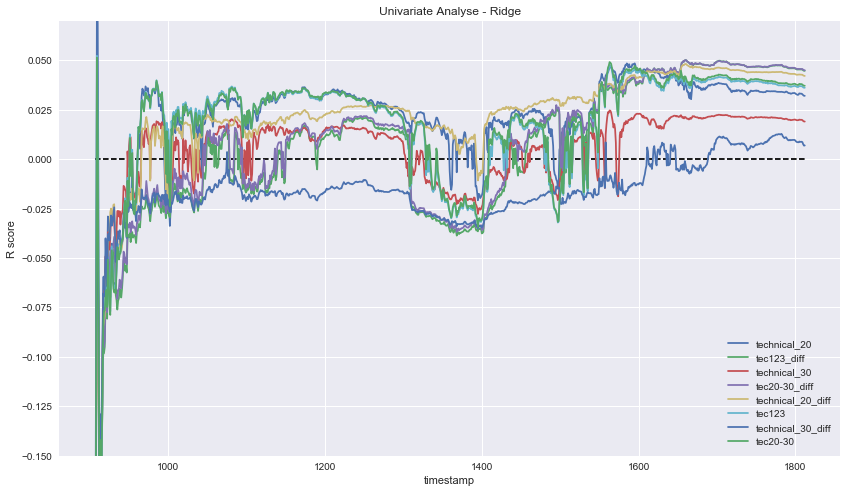

In [39]:
plt.title('Univariate Analyse - Ridge')
plt.xlabel('timestamp')
plt.ylabel('R score')
plt.plot([min_stamp, max_stamp], [0, 0], 'k--')
for key in reward.keys():
    plt.plot(range(min_stamp, max_stamp + 1), np.array(reward_ridge[key]) * 2, label=key)
plt.legend(loc='best')
plt.ylim(-0.15, 0.07)

(-0.15, 0.07)

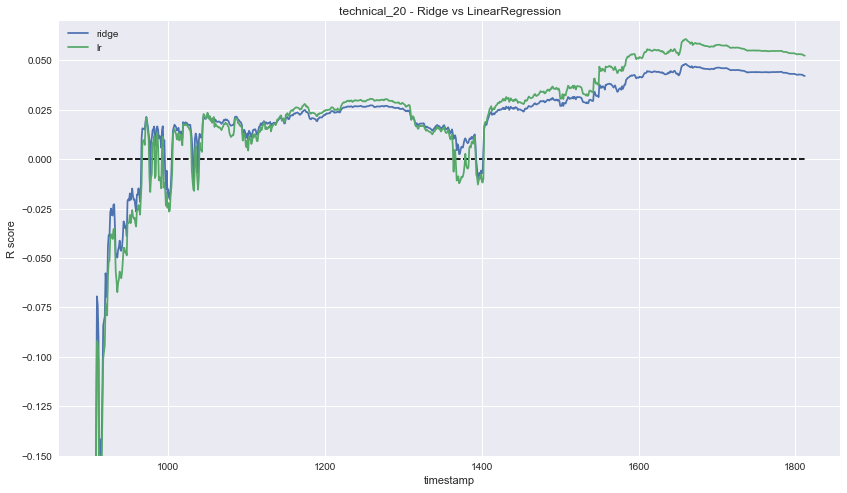

In [40]:
plt.title('technical_20 - Ridge vs LinearRegression')
plt.xlabel('timestamp')
plt.ylabel('R score')
plt.plot([min_stamp, max_stamp], [0, 0], 'k--')
plt.plot(range(min_stamp, max_stamp + 1), np.array(reward_ridge['technical_20_diff']) * 2, label='ridge')
plt.plot(range(min_stamp, max_stamp + 1), np.array(reward['technical_20_diff']) * 2, label='lr')
plt.legend(loc='best')
plt.ylim(-0.15, 0.07)

seems `LinearRegression` perfroms better overall, but `Ridge` performs better when `R_score < 0`, this may prevent future overfit 

# Bivariate  Analyse

In [45]:
reward_ridge_bi = defaultdict(list)
model = ridge
for i in range(1, len(feature_cols) - 1):
    for j in range(i + 1, len(feature_cols)):
        print('Processing', feature_cols[i], feature_cols[j])
        feature = [feature_cols[i], feature_cols[j]]
        model.fit(X_train.loc[y_is_within_cut, feature], y_train.loc[y_is_within_cut])
        stamp = min_stamp
        y_true_acc = []
        y_pred_acc = []
        while stamp <= max_stamp:
            test = X_test.loc[X_test.timestamp == stamp, feature]
            y_true = y_test.loc[X_test.timestamp == stamp]
            y_pred = model.predict(test)
    #         print(y_true.shape, y_pred.shape)
            y_true_acc.extend(list(y_true))
            y_pred_acc.extend(list(y_pred))
            reward_ridge_bi[(feature[0], feature[1])].append(twosigmafunc.R_score(np.array(y_pred_acc), np.array(y_true_acc)))
            stamp += 1


Processing tec123 tec123_diff
Processing tec123 tec20-30
Processing tec123 tec20-30_diff
Processing tec123 technical_20
Processing tec123 technical_30
Processing tec123 technical_20_diff
Processing tec123 technical_30_diff
Processing tec123_diff tec20-30
Processing tec123_diff tec20-30_diff
Processing tec123_diff technical_20
Processing tec123_diff technical_30
Processing tec123_diff technical_20_diff
Processing tec123_diff technical_30_diff
Processing tec20-30 tec20-30_diff
Processing tec20-30 technical_20
Processing tec20-30 technical_30
Processing tec20-30 technical_20_diff
Processing tec20-30 technical_30_diff
Processing tec20-30_diff technical_20
Processing tec20-30_diff technical_30
Processing tec20-30_diff technical_20_diff
Processing tec20-30_diff technical_30_diff
Processing technical_20 technical_30
Processing technical_20 technical_20_diff
Processing technical_20 technical_30_diff
Processing technical_30 technical_20_diff
Processing technical_30 technical_30_diff
Processing 

(-0.3, 0.16)

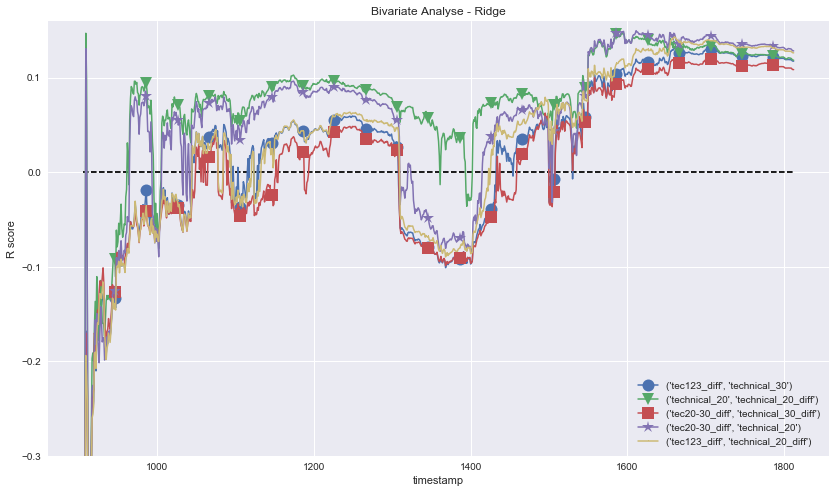

In [80]:
plt.title('Bivariate Analyse - Ridge')
plt.xlabel('timestamp')
plt.ylabel('R score')
plt.plot([min_stamp, max_stamp], [0, 0], 'k--')
for ind, key in enumerate(list(reward_ridge_bi.keys())[:5]):
    plt.plot(range(min_stamp, max_stamp + 1), np.array(reward_ridge_bi[key]) * 5,lw=1.5, marker=markers[ind], markersize=12, markevery=40, label=key)
plt.legend(loc='best')
plt.ylim(-0.3, 0.16)

`technical_20` `technical_20_diff` best

(-0.3, 0.16)

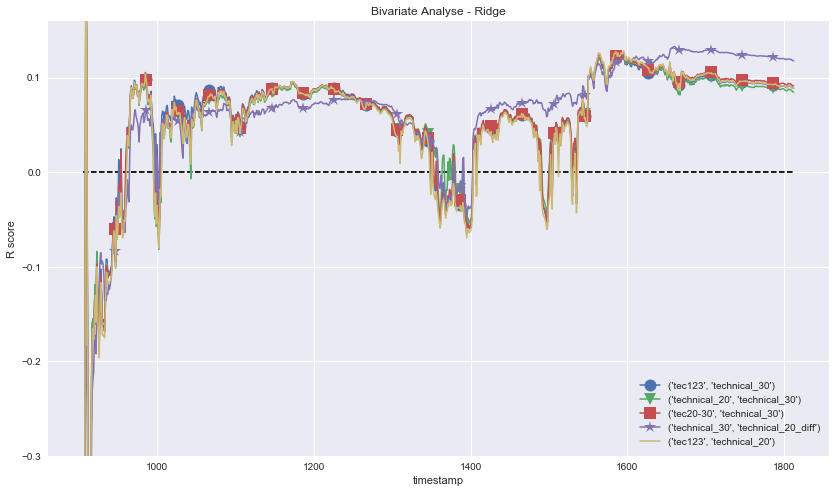

In [81]:
plt.title('Bivariate Analyse - Ridge')
plt.xlabel('timestamp')
plt.ylabel('R score')
plt.plot([min_stamp, max_stamp], [0, 0], 'k--')
for ind, key in enumerate(list(reward_ridge_bi.keys())[5:10]):
    plt.plot(range(min_stamp, max_stamp + 1), np.array(reward_ridge_bi[key]) * 5,lw=1.5, marker=markers[ind], markersize=12, markevery=40, label=key)
plt.legend(loc='best')
plt.ylim(-0.3, 0.16)

`technical_30` and `techncal_20_diff` best

(-0.3, 0.16)

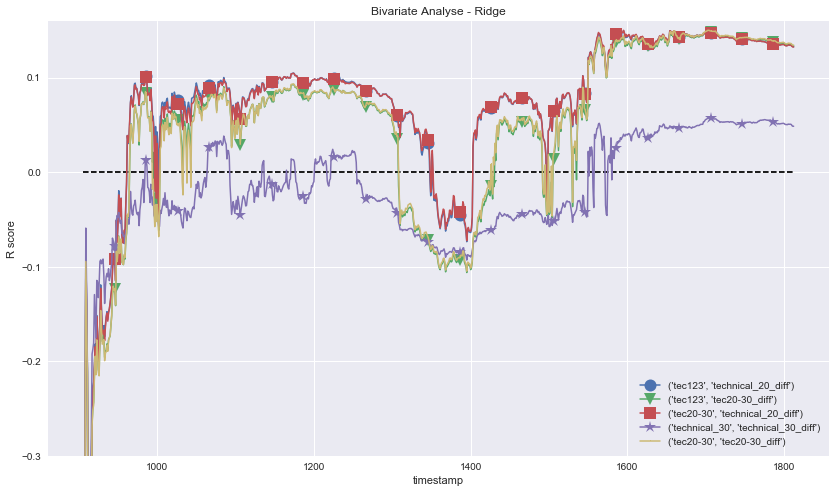

In [82]:
plt.title('Bivariate Analyse - Ridge')
plt.xlabel('timestamp')
plt.ylabel('R score')
plt.plot([min_stamp, max_stamp], [0, 0], 'k--')
for ind, key in enumerate(list(reward_ridge_bi.keys())[10:15]):
    plt.plot(range(min_stamp, max_stamp + 1), np.array(reward_ridge_bi[key]) * 5,lw=1.5, marker=markers[ind], markersize=12, markevery=40, label=key)
plt.legend(loc='best')
plt.ylim(-0.3, 0.16)

`tec20-30` and `technical_20_diff` best

(-0.3, 0.16)

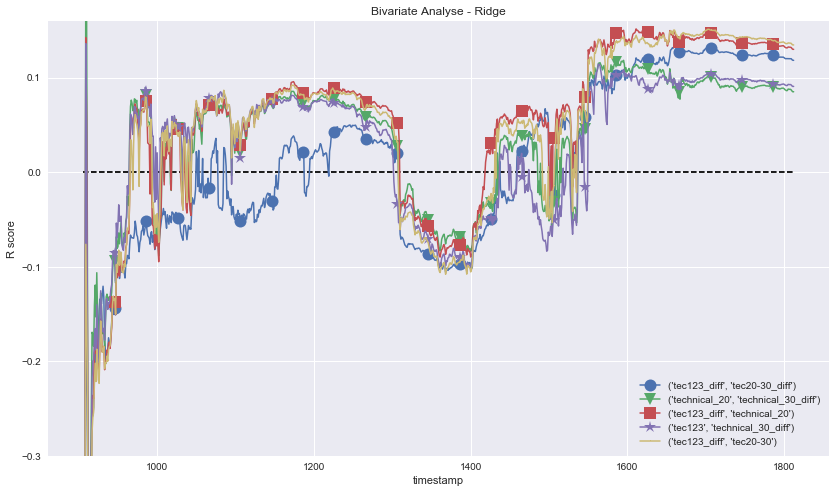

In [83]:
plt.title('Bivariate Analyse - Ridge')
plt.xlabel('timestamp')
plt.ylabel('R score')
plt.plot([min_stamp, max_stamp], [0, 0], 'k--')
for ind, key in enumerate(list(reward_ridge_bi.keys())[15:20]):
    plt.plot(range(min_stamp, max_stamp + 1), np.array(reward_ridge_bi[key]) * 5,lw=1.5, marker=markers[ind], markersize=12, markevery=40, label=key)
plt.legend(loc='best')
plt.ylim(-0.3, 0.16)

`tec123_diff` and `technical_20` best

(-0.3, 0.16)

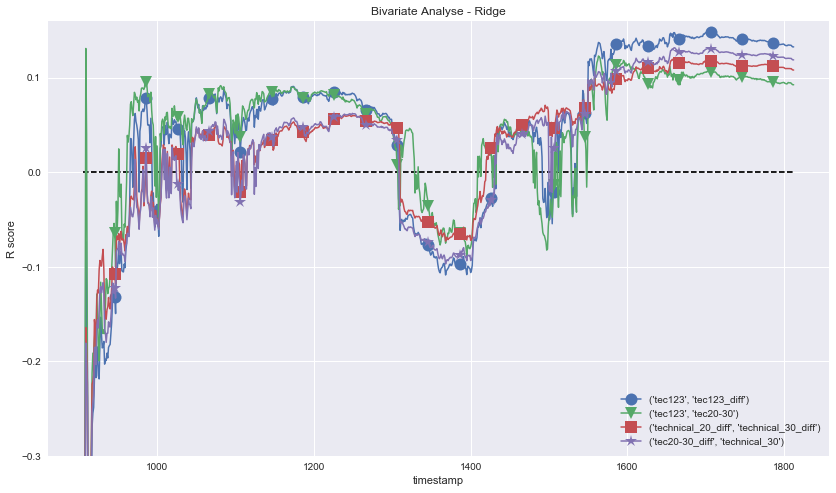

In [84]:
plt.title('Bivariate Analyse - Ridge')
plt.xlabel('timestamp')
plt.ylabel('R score')
plt.plot([min_stamp, max_stamp], [0, 0], 'k--')
for ind, key in enumerate(list(reward_ridge_bi.keys())[20:24]):
    plt.plot(range(min_stamp, max_stamp + 1), np.array(reward_ridge_bi[key]) * 5,lw=1.5, marker=markers[ind], markersize=12, markevery=40, label=key)
plt.legend(loc='best')
plt.ylim(-0.3, 0.16)

`tec123` and `tec20-30` best

(-0.3, 0.16)

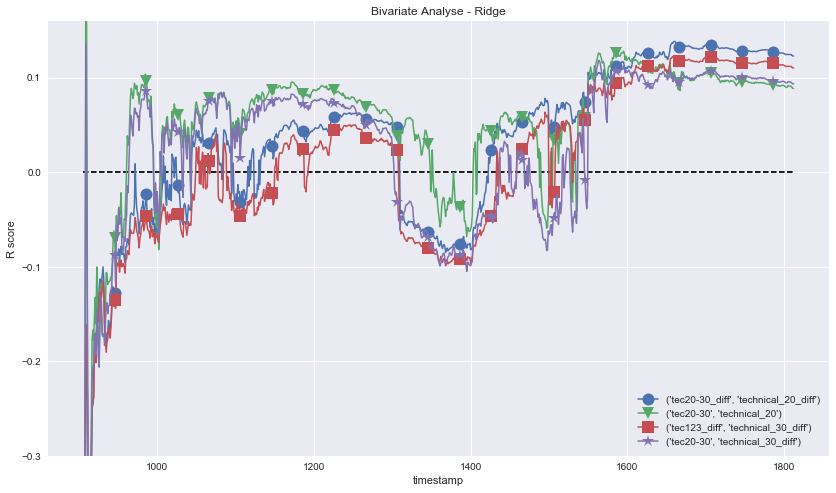

In [85]:
plt.title('Bivariate Analyse - Ridge')
plt.xlabel('timestamp')
plt.ylabel('R score')
plt.plot([min_stamp, max_stamp], [0, 0], 'k--')
for ind, key in enumerate(list(reward_ridge_bi.keys())[24:]):
    plt.plot(range(min_stamp, max_stamp + 1), np.array(reward_ridge_bi[key]) * 5,lw=1.5, marker=markers[ind], markersize=12, markevery=40, label=key)
plt.legend(loc='best')
plt.ylim(-0.3, 0.16)

`tec20-30` and `techncal_20` best

### Bset of Bivariate 

In [88]:
comb = [('technical_20', 'technical_20_diff'), ('tec123', 'tec20-30'), ('tec20-30', 'technical_20'), 
        ('tec123_diff','technical_20'), ('tec20-30', 'technical_20_diff'), ('technical_30', 'technical_20_diff')]

(-0.3, 0.66)

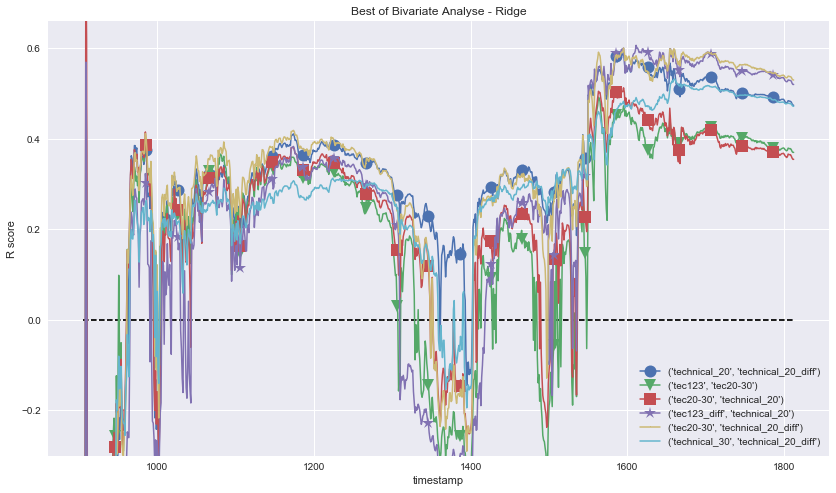

In [93]:
plt.title('Best of Bivariate Analyse - Ridge')
plt.xlabel('timestamp')
plt.ylabel('R score')
plt.plot([min_stamp, max_stamp], [0, 0], 'k--')
for ind, key in enumerate(comb):
    plt.plot(range(min_stamp, max_stamp + 1), np.array(reward_ridge_bi[key]) * 20,lw=1.5, marker=markers[ind], markersize=12, markevery=40, label=key)
plt.legend(loc='best')
plt.ylim(-0.3, 0.66)

remove ('tec123', 'tec20-30'), ('tec20-30', 'technical_20')

(-0.7, 0.38)

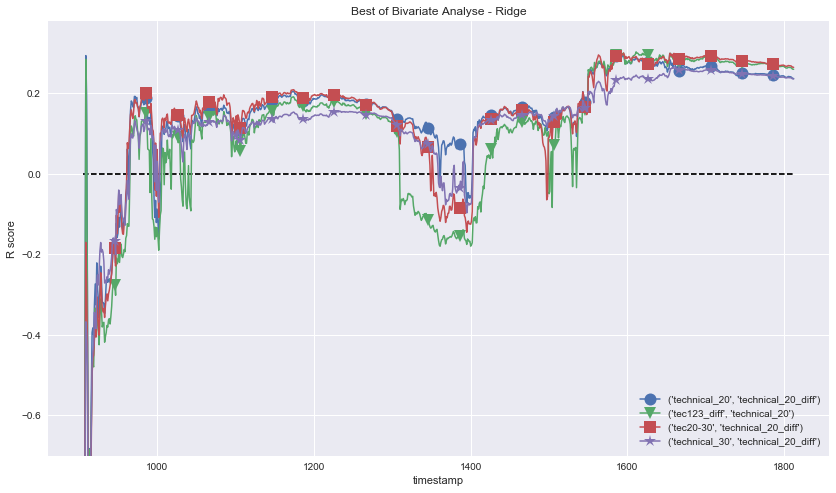

In [97]:
comb = [('technical_20', 'technical_20_diff'),
        ('tec123_diff','technical_20'), ('tec20-30', 'technical_20_diff'), ('technical_30', 'technical_20_diff')]
plt.title('Best of Bivariate Analyse - Ridge')
plt.xlabel('timestamp')
plt.ylabel('R score')
plt.plot([min_stamp, max_stamp], [0, 0], 'k--')
for ind, key in enumerate(comb):
    plt.plot(range(min_stamp, max_stamp + 1), np.array(reward_ridge_bi[key]) * 10,lw=1.5, marker=markers[ind], markersize=12, markevery=40, label=key)
plt.legend(loc='best')
plt.ylim(-0.7, 0.38)

In [98]:
for key in comb:
    print(key, 'score', reward_ridge_bi[key][-1])

('technical_20', 'technical_20_diff') score 0.0236813045695
('tec123_diff', 'technical_20') score 0.0259809708593
('tec20-30', 'technical_20_diff') score 0.026471868824
('technical_30', 'technical_20_diff') score 0.0235667898178


In [108]:
for key in feature_cols[1:]:
    print(key, reward_ridge[key][-1])

tec123 0.0180910943057
tec123_diff 0.0223666825029
tec20-30 0.0185931089862
tec20-30_diff 0.0225184240546
technical_20 0.0160440872361
technical_30 0.00953764483464
technical_20_diff 0.0210735989854
technical_30_diff 0.00347916328863


In [109]:
for key in feature_cols[1:]:
    print(key, reward[key][-1])

tec123 0.0181412000287
tec123_diff 0.0239844898867
tec20-30 0.0186498090908
tec20-30_diff 0.0245419026363
technical_20 0.0150692656111
technical_30 0.0103047240757
technical_20_diff 0.0261993906009
technical_30_diff -0.00570436109612


(-0.7, 0.38)

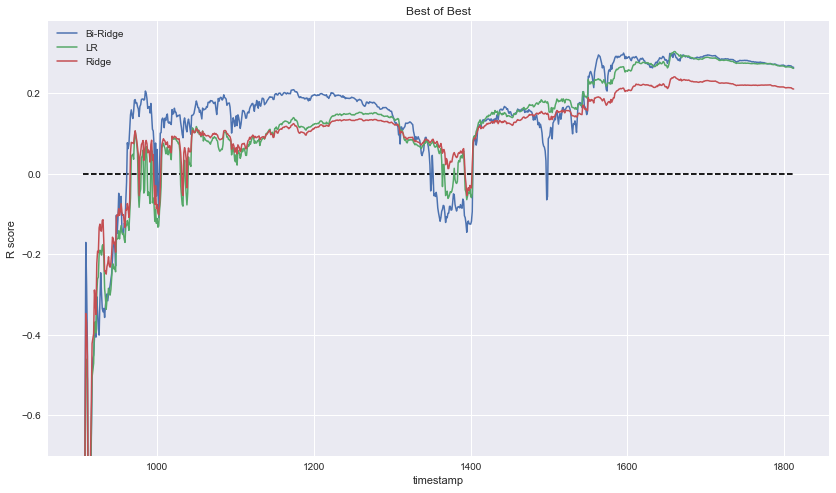

In [111]:
plt.title('Best of Best')
plt.xlabel('timestamp')
plt.ylabel('R score')
plt.plot([min_stamp, max_stamp], [0, 0], 'k--')
plt.plot(range(min_stamp, max_stamp + 1), np.array(reward_ridge_bi[('tec20-30', 'technical_20_diff')]) * 10,lw=1.5, label='Bi-Ridge')
plt.plot(range(min_stamp, max_stamp + 1), np.array(reward['technical_20_diff']) * 10,lw=1.5, label='LR')
plt.plot(range(min_stamp, max_stamp + 1), np.array(reward_ridge['technical_20_diff']) * 10,lw=1.5, label='Ridge')
plt.legend(loc='best')
plt.ylim(-0.7, 0.38)

Bivariate Ridge of features `tec20-30` and `technical_20_diff` performs better overall, while Univariate Rodge of `technical_20_diff` performs best when score < 0

## Using mixed model 

In [112]:
reward_mixed = []
model_1 = Ridge()
model_2 = Ridge()
model_1.fit(np.array(X_train.loc[y_is_within_cut, 'technical_20_diff']).reshape(-1,1), y_train.loc[y_is_within_cut])
model_2.fit(X_train.loc[y_is_within_cut, ['tec20-30', 'technical_20_diff']], y_train.loc[y_is_within_cut])
stamp = min_stamp
y_true_acc = []
y_pred_acc = []
while stamp <= max_stamp:
        test_1 = np.array(X_test.loc[X_test.timestamp == stamp, 'technical_20_diff']).reshape(-1,1)
        test_2 = X_test.loc[X_test.timestamp == stamp, ['tec20-30', 'technical_20_diff']]
        y_true = y_test.loc[X_test.timestamp == stamp]
        y_pred_1 = model_1.predict(test_1)
        y_pred_2 = model_2.predict(test_2)
        score = twosigmafunc.R_score(y_pred_2, y_true)
        if score >= 0:
            y_pred_acc.extend(list(y_pred_2))
        else:
            y_pred_acc.extend(list(y_pred_1))
#         print(y_true.shape, y_pred.shape)
        y_true_acc.extend(list(y_true))
        reward_mixed.append(twosigmafunc.R_score(np.array(y_pred_acc), np.array(y_true_acc)))
        stamp += 1

In [113]:
reward_mixed[-1]

0.032626636705005985

(-0.3, 0.38)

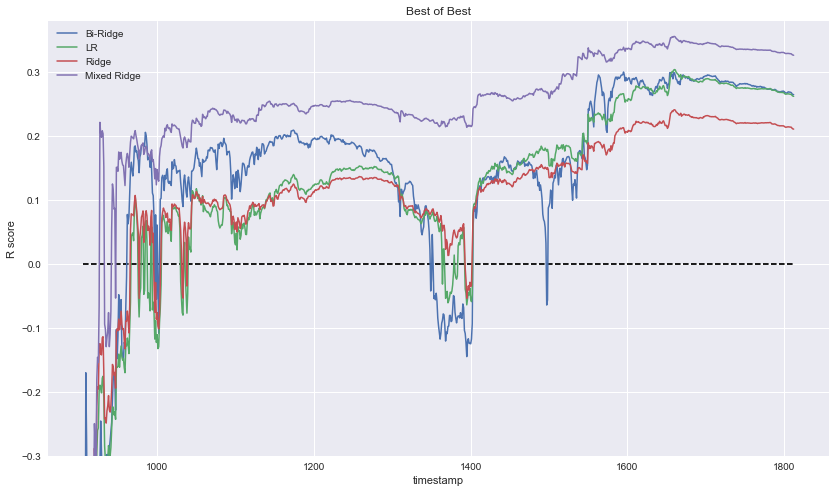

In [115]:
plt.title('Best of Best')
plt.xlabel('timestamp')
plt.ylabel('R score')
plt.plot([min_stamp, max_stamp], [0, 0], 'k--')
plt.plot(range(min_stamp, max_stamp + 1), np.array(reward_ridge_bi[('tec20-30', 'technical_20_diff')]) * 10,lw=1.5, label='Bi-Ridge')
plt.plot(range(min_stamp, max_stamp + 1), np.array(reward['technical_20_diff']) * 10,lw=1.5, label='LR')
plt.plot(range(min_stamp, max_stamp + 1), np.array(reward_ridge['technical_20_diff']) * 10,lw=1.5, label='Ridge')
plt.plot(range(min_stamp, max_stamp + 1), np.array(reward_mixed) * 10,lw=1.5, label='Mixed Ridge')
plt.legend(loc='best')
plt.ylim(-0.3, 0.38)

In [116]:
results = pd.DataFrame({'timestamp':range(min_stamp, max_stamp + 1), 
                        'Bi_Ridge': reward_ridge_bi[('tec20-30', 'technical_20_diff')],
                        'LR': reward['technical_20_diff'], 
                        'Ridge': reward_ridge['technical_20_diff'],
                        'Mixed_model': reward_mixed})

In [118]:
results.to_csv('Linear_R_score.csv')

# Predicting Rewards 
although reward can be used as flag to indicate which Ridge model to involve, however, in submit model, we can not get reward before we hand in our predictions, so let's predict reward now

In [15]:
-

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800


In [16]:
time_gp = train.groupby('timestamp')

In [17]:
del train

In [18]:
gp = time_gp.mean()[['technical_20_diff', 'tec20-30']]
gp.head()

,technical_20_diff,tec20-30
timestamp,,
0,0.000000e+00,0.000386
1,-3.222473e-04,0.000472
2,1.537294e-04,0.000511
3,-1.590888e-05,-0.000032
4,4.712250e-07,-0.000307


In [19]:
gp['timestamp'] = gp.index

In [20]:
gp['rew_1'] = reward_1[:]
gp['rew_2'] = reward_2[:]

In [21]:
gp['bi'] = gp.rew_1 < gp.rew_2

In [22]:
gp['tec20_std'] = time_gp.std()['technical_20_diff']
gp['tec20_30_std'] = time_gp.std()['tec20-30']
gp['tec20_max'] = time_gp.max()['technical_20_diff']
gp['tec20_min'] = time_gp.min()['technical_20_diff']
gp['tec20_30_max'] = time_gp.max()['tec20-30']
gp['tec20_30_min'] = time_gp.min()['tec20-30']

In [24]:
gp.rew_1 = gp.rew_1.shift()
gp.rew_2 = gp.rew_2.shift()
gp.fillna(0, inplace=True)

In [31]:
gp.head()

,technical_20_diff,tec20-30,timestamp,rew_1,rew_2,bi,tec20_std,tec20_30_std,tec20_max,tec20_min,tec20_30_max,tec20_30_min,technical_20_nan,technical_30_nan
timestamp,,,,,,,,,,,,,,
0,0.000000e+00,0.000386,0,0.000000,0.000000,True,0.000000,0.007681,0.000000,0.000000,0.033168,-0.036647,0.001333,0.001333
1,-3.222473e-04,0.000472,1,-0.070571,-0.061729,False,0.003028,0.006507,0.013369,-0.012672,0.026580,-0.029471,0.001333,0.001333
2,1.537294e-04,0.000511,2,-0.065288,-0.091070,False,0.002239,0.006825,0.016507,-0.009636,0.022925,-0.037371,0.001333,0.001333
3,-1.590888e-05,-0.000032,3,-0.206488,-0.231456,False,0.001778,0.007721,0.010776,-0.008120,0.019447,-0.037181,0.001333,0.001333
4,4.712250e-07,-0.000307,4,-0.081999,-0.120706,True,0.002525,0.008156,0.009547,-0.013342,0.016363,-0.039013,0.001333,0.001333


In [34]:
features_for_bi = [col for col in gp.columns if col not in ['timestamp', 'bi']]
y = gp.bi.astype(int)

In [35]:
features_for_bi

['technical_20_diff',
 'tec20-30',
 'rew_1',
 'rew_2',
 'tec20_std',
 'tec20_30_std',
 'tec20_max',
 'tec20_min',
 'tec20_30_max',
 'tec20_30_min',
 'technical_20_nan',
 'technical_30_nan']

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
rfc = RandomForestClassifier(n_estimators=256, n_jobs=-1, random_state=11)

add gradient of features here

In [36]:
diff_features = twosigmafunc.additional_features(features_for_bi, '_diff')
for feature, diff in zip(features_for_bi, diff_features):
    gp[diff] = gp[feature].diff()
gp.fillna(0, inplace=True)

In [37]:
gp.head()

,technical_20_diff,tec20-30,timestamp,rew_1,rew_2,bi,tec20_std,tec20_30_std,tec20_max,tec20_min,...,rew_1_diff,rew_2_diff,tec20_std_diff,tec20_30_std_diff,tec20_max_diff,tec20_min_diff,tec20_30_max_diff,tec20_30_min_diff,technical_20_nan_diff,technical_30_nan_diff
timestamp,,,,,,,,,,,,,,,,,,,,,
0,0.000000e+00,0.000386,0,0.000000,0.000000,True,0.000000,0.007681,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,-3.222473e-04,0.000472,1,-0.070571,-0.061729,False,0.003028,0.006507,0.013369,-0.012672,...,-0.070571,-0.061729,0.003028,-0.001174,0.013369,-0.012672,-0.006587,0.007176,0.0,0.0
2,1.537294e-04,0.000511,2,-0.065288,-0.091070,False,0.002239,0.006825,0.016507,-0.009636,...,0.005284,-0.029341,-0.000789,0.000318,0.003138,0.003036,-0.003655,-0.007900,0.0,0.0
3,-1.590888e-05,-0.000032,3,-0.206488,-0.231456,False,0.001778,0.007721,0.010776,-0.008120,...,-0.141200,-0.140386,-0.000461,0.000896,-0.005731,0.001516,-0.003478,0.000190,0.0,0.0
4,4.712250e-07,-0.000307,4,-0.081999,-0.120706,True,0.002525,0.008156,0.009547,-0.013342,...,0.124489,0.110749,0.000746,0.000435,-0.001229,-0.005221,-0.003084,-0.001832,0.0,0.0


In [38]:
features_for_bi.extend(diff_features)

In [39]:
features_for_bi

['technical_20_diff',
 'tec20-30',
 'rew_1',
 'rew_2',
 'tec20_std',
 'tec20_30_std',
 'tec20_max',
 'tec20_min',
 'tec20_30_max',
 'tec20_30_min',
 'technical_20_nan',
 'technical_30_nan',
 'technical_20_diff_diff',
 'tec20-30_diff',
 'rew_1_diff',
 'rew_2_diff',
 'tec20_std_diff',
 'tec20_30_std_diff',
 'tec20_max_diff',
 'tec20_min_diff',
 'tec20_30_max_diff',
 'tec20_30_min_diff',
 'technical_20_nan_diff',
 'technical_30_nan_diff']

In [41]:
parameter_grid = {
                 'max_depth': [3, 5, None],
                 'max_features': ['sqrt', 0.5, None]
                 }

cross_validation = StratifiedKFold(5)

grid_search = GridSearchCV(rfc,
                           param_grid=parameter_grid,
                           cv=cross_validation, n_jobs=-1)

grid_search.fit(gp[features_for_bi], y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=256, n_jobs=-1, oob_score=False, random_state=11,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': ['sqrt', 0.5, None], 'max_depth': [3, 5, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [42]:
np.mean(y == grid_search.predict(gp[features_for_bi]))

0.71980143408714836

In [43]:
imp = pd.DataFrame({'feature': features_for_bi, 'weight':grid_search.best_estimator_.feature_importances_}).sort_values(
    'weight', ascending=False)

In [44]:
imp

,feature,weight
6,tec20_max,0.057889
16,tec20_std_diff,0.056377
12,technical_20_diff_diff,0.054687
4,tec20_std,0.054156
7,tec20_min,0.053378
5,tec20_30_std,0.052354
13,tec20-30_diff,0.050402
17,tec20_30_std_diff,0.050241
1,tec20-30,0.047579
19,tec20_min_diff,0.047071


In [45]:
grid_search.best_params_

{'max_depth': 5, 'max_features': 'sqrt'}

In [47]:
rfc = RandomForestClassifier(n_estimators=256, max_depth=5, max_features='sqrt', random_state=11)
rfc.fit(gp[imp.feature[:-4]], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=256, n_jobs=1, oob_score=False, random_state=11,
            verbose=0, warm_start=False)

In [50]:
np.mean(y == rfc.predict(gp[imp.feature[:-4]]))

0.71759514616657472

In [51]:
gp.bi.mean()

0.46938775510204084